Set up

May want to return to spec params and put in a config file. for now these are bing hard coded into the my_melspec function

In [20]:
# tutorial imports, check later to see which may be redundant

# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import SpectrogramPreprocessor
from opensoundscape.ml.datasets import AudioFileDataset, AudioSplittingDataset


# helper function for displaying a sample as an image
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import random
import subprocess
import IPython.display as ipd

In [21]:
# Imports by ben
import json

In [22]:
# path to data
dataset_path = r'/home/ben/data/full_dataset/'
json_path = r'/home/ben/data/dataset.json'

In [23]:
# Beware below! Had plotting problems with matplotlib in wsl vscode so may need to play 

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

In [24]:
# what does this do 
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Accessing data
The open soundscape tutorial loads some custom datasets and puts these in a csv. So we must read the JSON file and produce a csv of this.

In [25]:
# Load the JSON data from the file
with open(json_path, "r") as file:
    data = json.load(file)

# Convert the list of dictionaries (which is the value of the main dictionary) into a DataFrame
df = pd.DataFrame(data[list(data.keys())[0]])

### Initialise preprocessor

In [27]:
# Create a dataframe with just file_path and a class column (req for AudioFileDataset)
transformed_df = df[['file_name', 'class']].copy()

# rename 'file_name' column to 'file'
transformed_df.rename(columns={'file_name': 'file'}, inplace=True)

# set file to be the index for AudioFileDataset
transformed_df.set_index('file', inplace=True)

# set all classes to 1 as AudioFileDataset requires class
transformed_df['class'] = 1

# append dataset_path to start of file_name column
transformed_df.index = dataset_path + transformed_df.index
transformed_df.head()

,class
file,
/home/ben/data/full_dataset/test_data.australia.class0.degraded_moth32.20230209_162000.wav,1
/home/ben/data/full_dataset/test_data.australia.class0.degraded_moth32.20230209_164400.wav,1
/home/ben/data/full_dataset/test_data.australia.class0.degraded_moth32.20230209_171600.wav,1
/home/ben/data/full_dataset/test_data.australia.class0.degraded_moth32.20230209_184000.wav,1
/home/ben/data/full_dataset/test_data.australia.class0.degraded_moth32.20230209_195200.wav,1


In [8]:
# initialize the preprocessor (forget what this does?)
pre = SpectrogramPreprocessor(sample_duration=1.92)

# initialize the dataset
dataset = AudioFileDataset(transformed_df, pre)

# change the bandpass from the default to 8khz
dataset.preprocessor.pipeline.bandpass.set(min_f=0,max_f=8000)

## Adjust to work with mel spectrograms

In [9]:
# for redefining the actions in the dataset.preprocessor.pipeline
from opensoundscape import Action
from opensoundscape.spectrogram import MelSpectrogram


# custom functions to produce melspetrograms
def melspec_linear_to_db(melspec):
    
    # because there's an underflow error during MelSpectrogram.from_audio() with dB_scale = True,
    # we instead perform dB scaling afterwards
    # which for some mysterious reason works
    
    melspectrogram = 10 * np.log10(
                    melspec.spectrogram,
                    where=melspec.spectrogram > 0,
                    out=np.full(melspec.spectrogram.shape, -np.inf),)

    # limit the decibel range (-100 to -20 dB by default)
    # values below lower limit set to lower limit,
    # values above upper limit set to uper limit
    min_db, max_db = melspec.decibel_limits
    melspectrogram[melspectrogram > max_db] = max_db
    melspectrogram[melspectrogram < min_db] = min_db

    return MelSpectrogram(times=melspec.times,
                          frequencies=melspec.frequencies,
                          spectrogram=melspectrogram,
                          decibel_limits=melspec.decibel_limits,                   
    )

def my_melspec(audio):
    melspec_linear = MelSpectrogram.from_audio(audio,dB_scale=False, window_samples = 512) #adjust params, use MelSpectrogram.from_audio to see what these are
    melspec_db = melspec_linear_to_db(melspec_linear)
    return melspec_db

melspec_action = Action(my_melspec)


# redfine the bandpass action to work on melspecs
melspec_bandpass_action = Action(MelSpectrogram.bandpass, min_f = 0, max_f = 8000)

# redefine the spectrogram function to melspec using the functions above
dataset.preprocessor.pipeline['to_spec'] = melspec_action

# Change to bandpass melspecs not normal specs
dataset.preprocessor.pipeline['bandpass'] = melspec_bandpass_action

In [10]:
# Check shape of each sample
dataset[0].data.shape

torch.Size([3, 224, 224])

/home/ben/miniconda3/envs/ben-python-3.9-env/lib/python3.11/site-packages/opensoundscape/preprocess/utils.py:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(tensors) // columns + 1, columns, i + 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


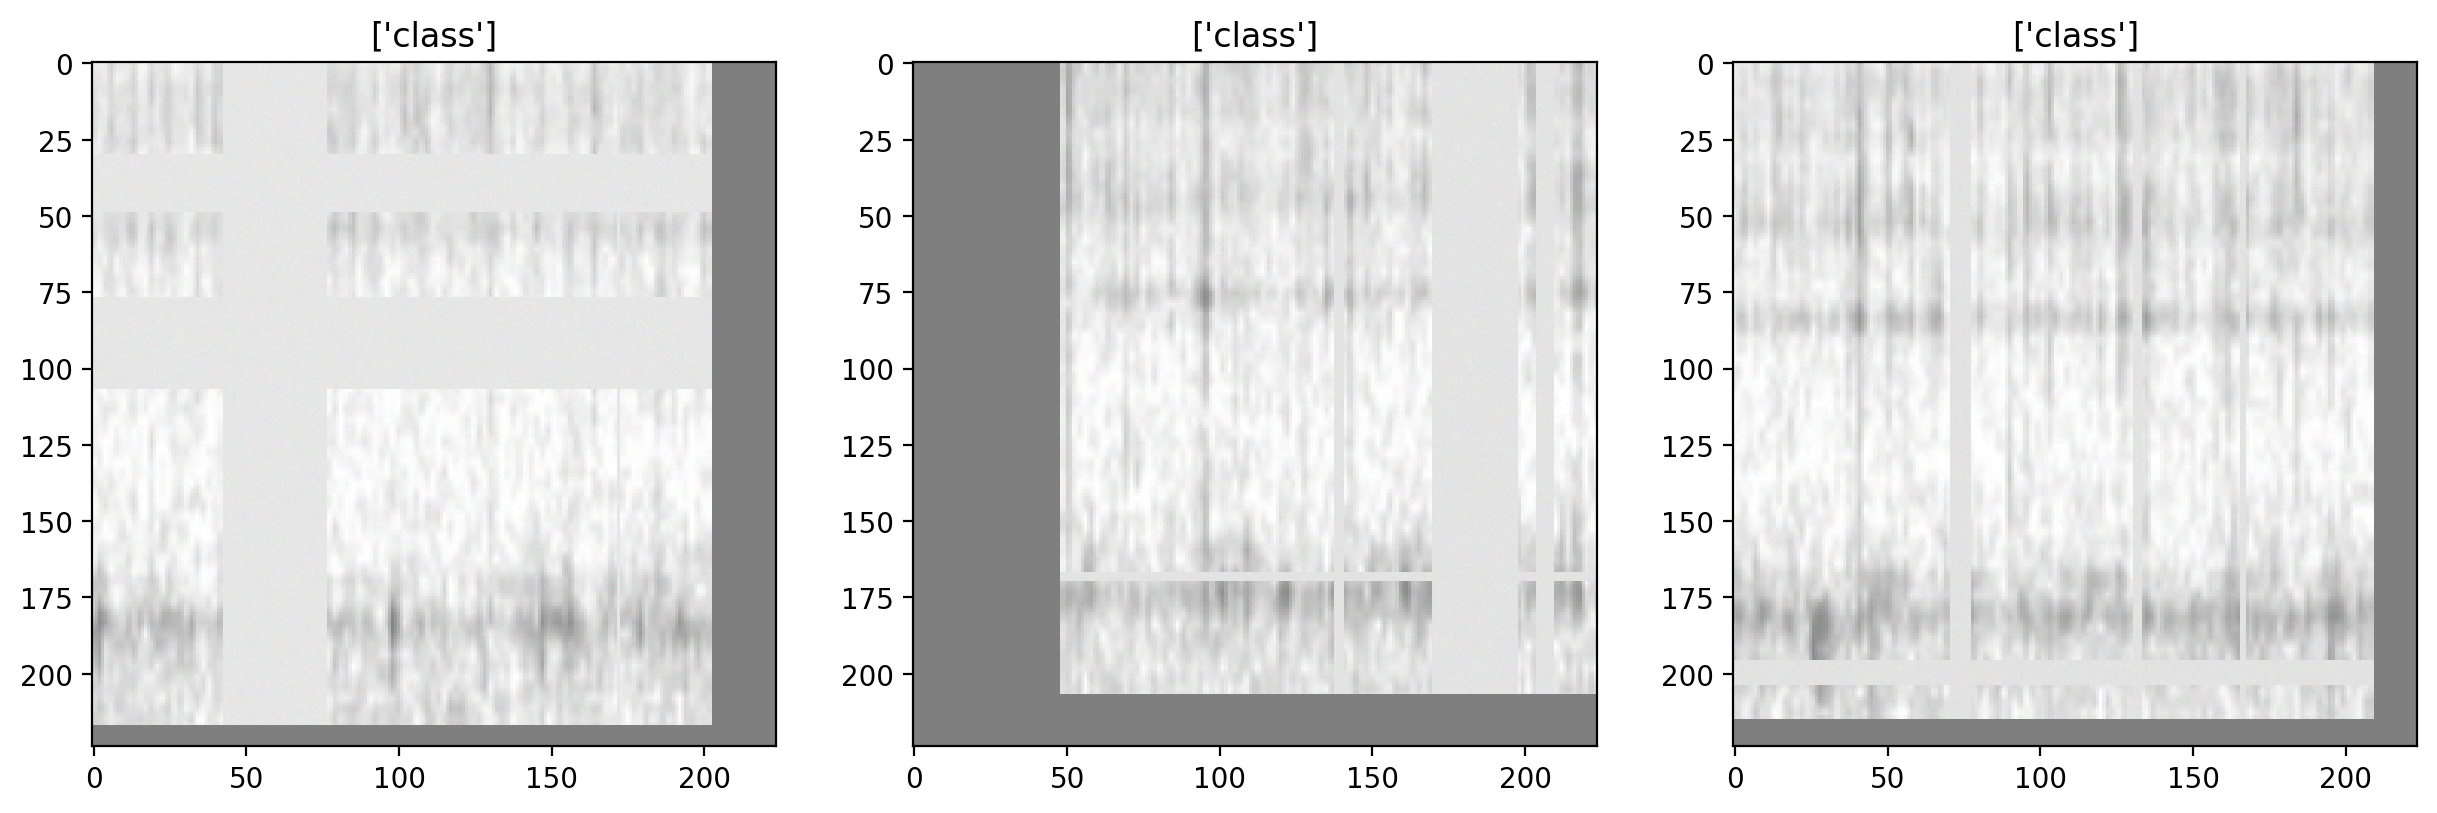

In [224]:
# sample.data returns the tensor
# sample.label returns the label (all 1)

dataset.bypass_augmentations = False # change to True to prevent augmentations
tensors = [dataset[i].data for i in range(3)]
sample_labels = [list(dataset[i].labels[dataset[i].labels>0].index) for i in range(3)]

_ = show_tensor_grid(tensors,3,labels=sample_labels)

# View traditional melspecs
The above shows us melspecs as the network will receive these, we can also plot more treditionally just to view these

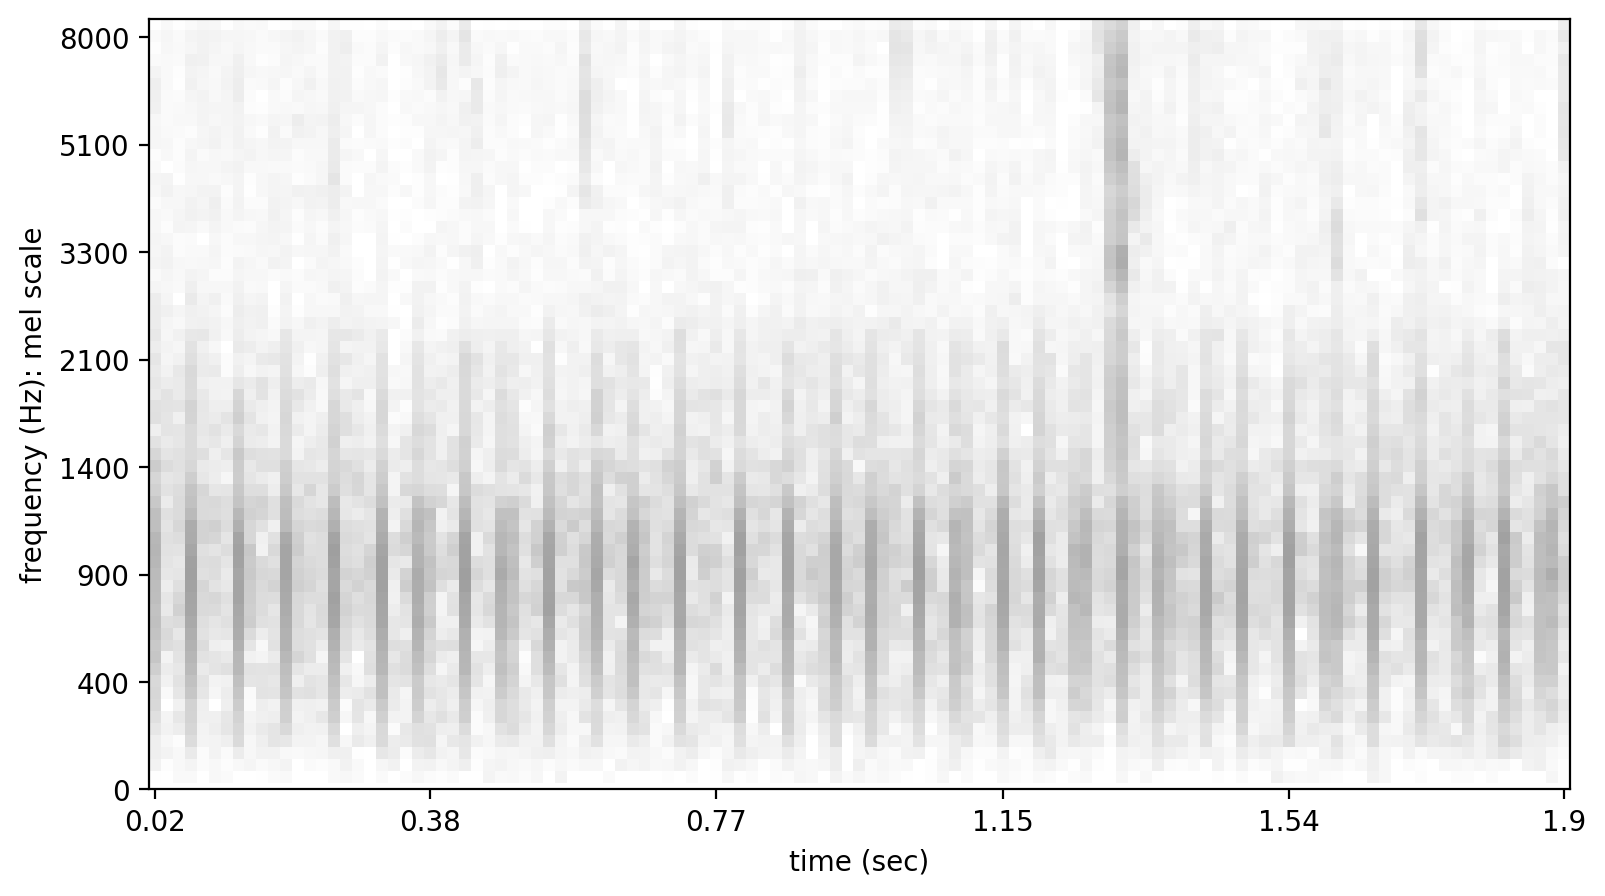

In [223]:
example_file = '/home/ben/data/full_dataset/train_data.convmet.010175.florida_keys.bioph_rattle.wav'
s = dataset.preprocessor.forward(example_file, break_on_key = 'bandpass') # this breaks part of the pipeline to stop preprocessing further
s.data.plot()